<style>
    h1 {
      color: #0078d4
    }
</style>
<h1>Image classification for bone fractures</h1>

<p>The goal of this project is to classify images of different bone fractures into different categories.
Data set that will be used in this project contains 1130 images of 10 different types of bone
brakes such as <i>avulsion fractures, comminuted fractures, fracture-dislocations, greenstick
fractures, hairline fractures, impacted fractures, longitudinal fractures, oblique fractures,
pathological fractures, and spiral fractures</i>. By using machine learning algorithms, it will be
possible to predict types of a specific bone break which theoretically could lead to patients getting better
treatment and improve their health outcomes. </p>

<style>
    h4 {
        color:rgb(0, 212, 184)
    }
</style>
<h4>Dataset Information</h4>
<ul>
    <li><strong>Name:</strong> Bone Break Classification Dataset</li>
    <li><strong>Type:</strong> Open Source Dataset</li>
    <li><strong>Author:</strong> Curso</li>
    <li><strong>Source:</strong> 
      <a href="https://universe.roboflow.com/curso-rphcb/bone-break-classification" target="_blank">Roboflow Universe</a>
    </li>
    <li><strong>Publisher:</strong> Roboflow</li>
    <li><strong>Published:</strong> February 2024</li>
    <li><strong>License:</strong> Creative Commons Attribution 4.0 (CC BY 4.0)</li>
    <li><strong>Note:</strong> Visited on 29.11.2024.</li>
    <li><strong>Acquired from:</strong> 
      <a href="https://www.kaggle.com/datasets/pkdarabi/bone-break-classification-image-dataset/data" target="_blank">Kaggle</a>
    </li>
</ul>


<h4>Leading images</h4>

In [74]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models

In [75]:
#leading images in baches of 20
images = tf.keras.preprocessing.image_dataset_from_directory(
    "Bone Break Classification/", #images location
    image_size=(200, 200),  #specifying resolution
    batch_size=64           #leading them in batces
)

Found 1129 files belonging to 10 classes.


In [76]:
#displaying image labels
classes = images.class_names
print(classes)

['Avulsion fracture', 'Comminuted fracture', 'Fracture Dislocation', 'Greenstick fracture', 'Hairline Fracture', 'Impacted fracture', 'Longitudinal fracture', 'Oblique fracture', 'Pathological fracture', 'Spiral Fracture']


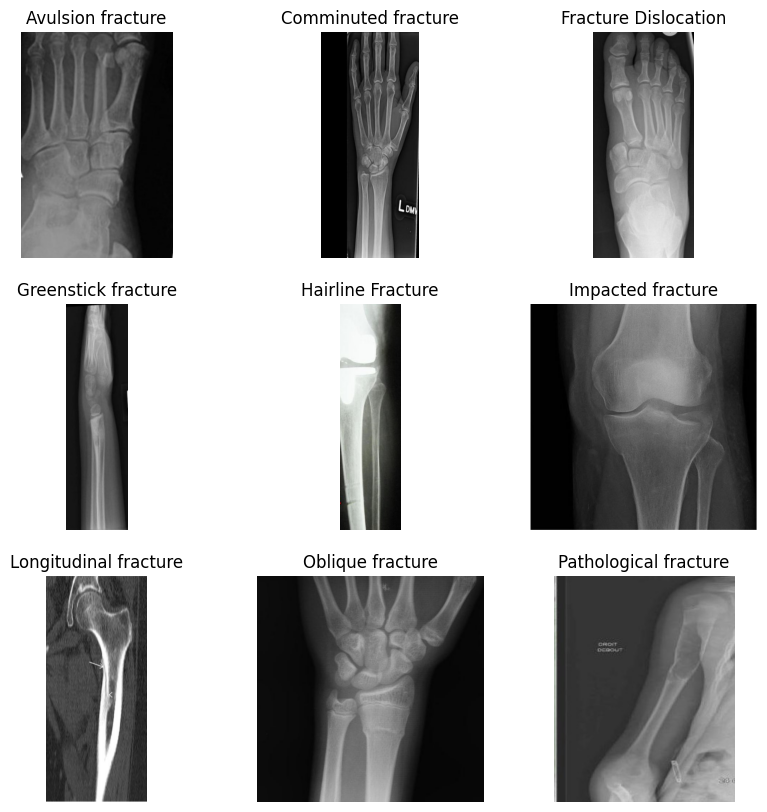

In [77]:
#plotting 1 image from each class
plt.figure(figsize=(10, 10))
for class_name in classes[:9]: #limit to 9 presenting classes
    plt.subplot(3, 3, classes.index(class_name) + 1)
    location = "Bone Break Classification/" + class_name
    for image_path in os.listdir(location)[:3]:
        image = plt.imread(os.path.join(location, image_path))
        plt.imshow(image)
        plt.title(class_name)
        plt.axis("off")
plt.show()

<style>
    h4 {
        color:rgb(0, 212, 184)
    }
</style>
<h4>Data Cleaning</h4>
<p>It was not possible to clean data, by for example checking if images have corrected labels or if they have good quality as I am lacking knowledge in this area and I do not have any possibility to check this.</p>

<style>
    h4 {
        color:rgb(0, 212, 184)
    }
</style>
<h4>Normalizing images</h4>

Normalizing images is done in order to scale pixel values that can be by default between 0 and 255. By scaling them values will be between 0 and 1. Scaling images makes classification models improve their performance.

In [78]:
#nomalizing images
images = images.map(lambda x,y: (x/255, y))

<style>
    h4 {
        color:rgb(0, 212, 184)
    }
</style>
<h4>Splitting data</h4>

Images will be split into test, train and validation set.
Important! Images will be split in baches of 20.

In [79]:
#shuffling images to get randomness
images = images.shuffle(buffer_size=1000, seed=42)

#spliiting images into train, test and validation (70%, 20%, 10%)
train_size = int(len(images)*.7)
val_size = int(len(images)*.2)
test_size = int(len(images)*.1)

train_set = images.take(train_size)
val_set = images.skip(train_size).take(val_size)
test_set = images.skip(train_size+val_size).take(test_size)

<style>
    h4 {
        color:rgb(0, 212, 184)
    }
</style>
<h4>Data augmentation</h4>

Data augmentation is important in order to avoid overfitting. By applying augmentation images can be flipped or rotated to random angle. That will make the model to learn from variates of the same class, and it will be especially useful is the model would be applied to new, unseen data.

In [80]:
#adding data augmentation
images_augmented = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),#randomly flipping images
    layers.RandomRotation(0.2),#ransomly rotating
    layers.RandomZoom(0.1),#randomly zooming images
])

#applying augmentation on my images
AUTOTUNE = tf.data.AUTOTUNE
train_set = train_set.map(lambda x, y: (images_augmented(x), y), num_parallel_calls=AUTOTUNE)
val_set = val_set.map(lambda x, y: (images_augmented(x), y), num_parallel_calls=AUTOTUNE)

<style>
    h4 {
        color: #d4007c
    }
</style>
<h4>Building models</h4>

<style>
    h4 {
        color:rgb(0, 212, 184)
    }
</style>
<h4>Model 1: EfficientNetB0</h4>

This is already prebuilt deep convolutional neural network model. It will be used as a base when building my model.

<b>Building the model</b>

In [81]:
#leading EfficientNetB0 to use it as a base for my model; top layer will not be included
#input is  200, 200, 3 means image dimensions 200X200 and.... channel 3 is because images are having 3 values for RGB
efficientnet_base = EfficientNetB0(include_top=False, input_shape=(200, 200, 3))
for layer in efficientnet_base.layers:
    layer.trainable = False  #preptrained layers will not be updated

#Building the model
efficientNetB0_model = models.Sequential([
    efficientnet_base,
    layers.BatchNormalization(),
    layers.ReLU(),

    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    #to reduce overfitting
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

#adding compiler and defining parameters
#sparse_categorical_crossentropy is used as there are multiple classes and they are saved as numbers, integers
efficientNetB0_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


<b>Training the model</b>

In [82]:
#model will be trained and training progress will be saved
efficientNetB0_history = efficientNetB0_model.fit(train_set, epochs=200, validation_data=val_set)

Epoch 1/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.1188 - loss: 2.3862 - val_accuracy: 0.1510 - val_loss: 2.2846
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.1552 - loss: 2.2900 - val_accuracy: 0.1354 - val_loss: 2.2945
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.1126 - loss: 2.2994 - val_accuracy: 0.1146 - val_loss: 2.2998
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.1198 - loss: 2.2969 - val_accuracy: 0.1094 - val_loss: 2.2931
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.1266 - loss: 2.2813 - val_accuracy: 0.1042 - val_loss: 2.2970
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.1170 - loss: 2.3013 - val_accuracy: 0.1146 - val_loss: 2.2977
Epoch 7/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.1253 - loss: 2.2917 - val_accuracy: 0.1243 - val_loss: 2.2980
Epoch 8/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.1318 - loss: 2.2847 - val_accuracy: 0.1510 - v

Displaying training process

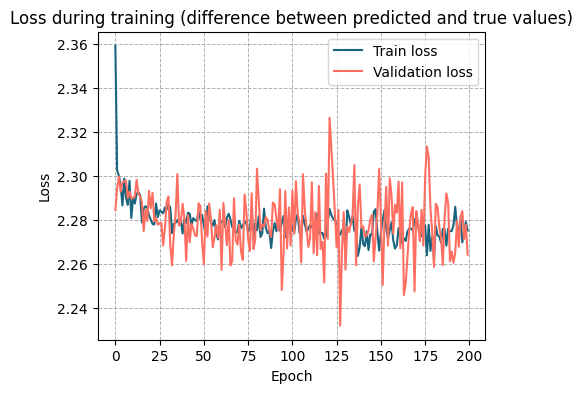

In [83]:
#colors to display plot
colors = ["#19647E", "#FF6F61"]

#showing the plot
plt.figure(figsize=(5,4))
plt.plot(efficientNetB0_history.history['loss'], label='Train loss', color=colors[0])
plt.plot(efficientNetB0_history.history['val_loss'], label='Validation loss', color=colors[1])
plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)
plt.title('Loss during training (difference between predicted and true values)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Making predictions on test data

In [84]:
#efficientNetB0_image_labels will store current labels for images
#efficientNetB0_imaged_labels will store values that the model predicted
efficientNetB0_image_labels = []
efficientNetB0_predicted_labels = []

#making predictions on the test set and getting both true and predicted labels
for images, labels in test_set:
    efficientNetB0_predictions = efficientNetB0_model.predict(images)
    efficientNetB0_image_labels.extend(labels.numpy())
    efficientNetB0_predicted_labels.extend(efficientNetB0_predictions.argmax(axis=1))

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 929ms/step


<style>
    h4 {
        color: #d4007c
    }
</style>
<h4>Model evaluation</h4>

Accuracy

In [85]:
#counting and printing accuracy
efficientNetB0_test_loss, efficientNetB0_test_acc = efficientNetB0_model.evaluate(test_set)
print(f"Accuracy: {efficientNetB0_test_acc}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1562 - loss: 2.2994
Accuracy: 0.15625


Classification report

In [86]:
#counting and printing classification report
efficientNetB0_class_report = classification_report(efficientNetB0_image_labels, efficientNetB0_predicted_labels, target_names=classes, zero_division=0)
print(efficientNetB0_class_report)

                       precision    recall  f1-score   support

    Avulsion fracture       0.00      0.00      0.00         5
  Comminuted fracture       0.00      0.00      0.00         7
 Fracture Dislocation       0.14      1.00      0.25         9
  Greenstick fracture       0.00      0.00      0.00         3
    Hairline Fracture       0.00      0.00      0.00         6
    Impacted fracture       0.00      0.00      0.00         8
Longitudinal fracture       0.00      0.00      0.00         5
     Oblique fracture       0.00      0.00      0.00         5
Pathological fracture       0.00      0.00      0.00        11
      Spiral Fracture       0.00      0.00      0.00         5

             accuracy                           0.14        64
            macro avg       0.01      0.10      0.02        64
         weighted avg       0.02      0.14      0.03        64



Confusion matrix

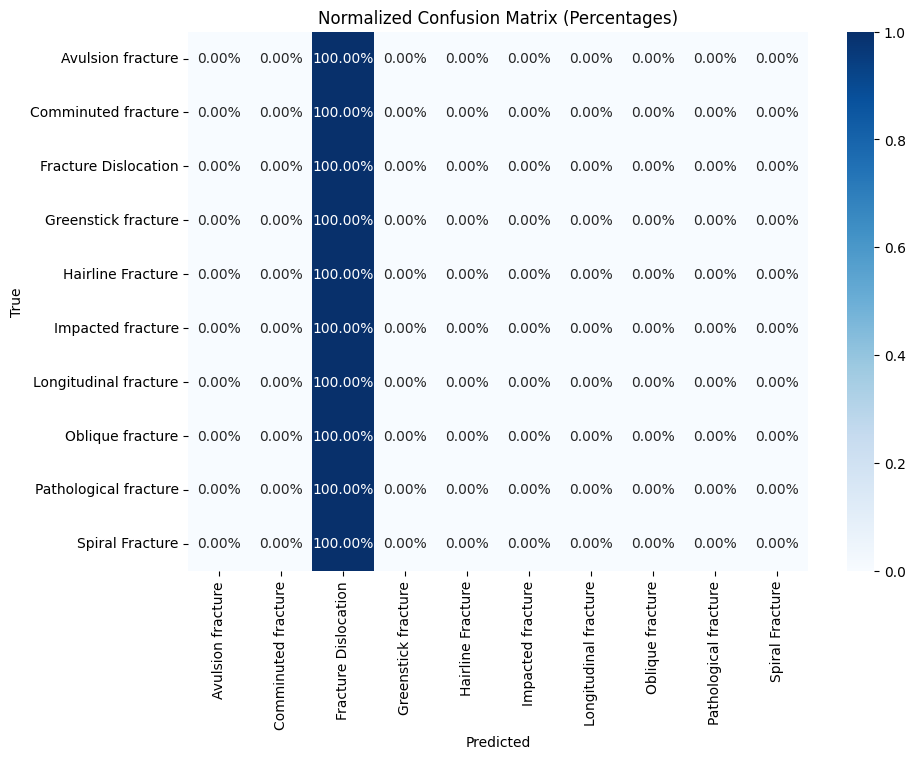

In [87]:
#computing conf. matrix
cm = confusion_matrix(efficientNetB0_image_labels, efficientNetB0_predicted_labels)

#normalizing confusion matrix by dividing each value by the total number of samples in the true class
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

#dsipalying confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix (Percentages)')
plt.show()

<style>
    h4 {
        color:rgb(0, 212, 184)
    }
</style>
<h4>Model 2: VGG16 - deep convolutional neural network</h4>

VGG16 is a pre-trained neural network. This model allows customization of the top layers by modifying or replacing them as it will be done in this assignment.

<b>Building the model</b>

In [88]:
#leading the base of this model byt excluding the top layers, input 200, 200, 3 means image dimensions 200X200 and....
#IMPORTANT
#channel 3 is because images are having 3 values for RGB, as those images are black and white I should use 1; however this model doesn't work with 1 channel
vgg16_base = VGG16(include_top=False, input_shape=(200, 200, 3))

#freezing the base layers from vgg16 models as they should not be updated
for layer in vgg16_base.layers:
    layer.trainable = False

#defining the model
#model will use vgg16 model's base as base
vgg16_model = models.Sequential([
    vgg16_base,
    layers.BatchNormalization(), #adding a batch normalization layer
    layers.ReLU(), #activation function will be relu
    #adding layers
    layers.Conv2D(512, (3, 3), activation=None),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

#adding compiler and defining parameters
#sparse_categorical_crossentropy is used as there are multiple classes and they are saved as numbers, integers
vgg16_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


<b>Training the model</b>

In [89]:
#model will be trained and training progress will be saved
vgg16_history = vgg16_model.fit(train_set, validation_data=val_set, epochs=200)

Epoch 1/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 120s 8s/step - accuracy: 0.1093 - loss: 2.6793 - val_accuracy: 0.0833 - val_loss: 2.4730
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 90s 7s/step - accuracy: 0.1537 - loss: 2.3876 - val_accuracy: 0.1302 - val_loss: 2.3064
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 91s 8s/step - accuracy: 0.1866 - loss: 2.2229 - val_accuracy: 0.1510 - val_loss: 2.2582
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 92s 8s/step - accuracy: 0.2273 - loss: 2.1832 - val_accuracy: 0.1354 - val_loss: 2.2242
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 89s 7s/step - accuracy: 0.2305 - loss: 2.0992 - val_accuracy: 0.1667 - val_loss: 2.2196
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 91s 8s/step - accuracy: 0.2776 - loss: 2.0641 - val_accuracy: 0.1771 - val_loss: 2.2349
Epoch 7/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 98s 8s/step - accuracy: 0.2908 - loss: 2.0185 - val_accuracy: 0.1927 - val_loss: 2.1781
Epoch 8/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 92s 8s/step - accuracy: 0.2530 - loss: 2.0591 - val_accuracy: 0.1875 - 

Displaying training process

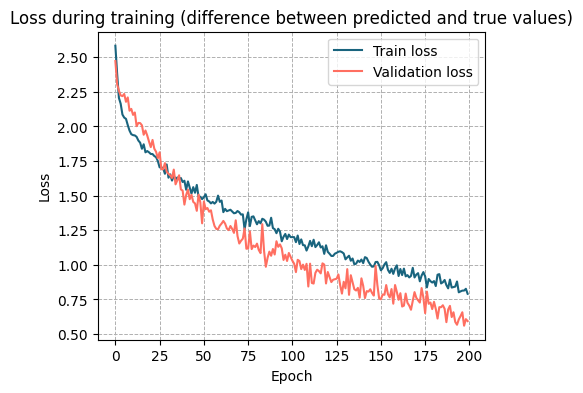

In [90]:
#showing the plot
plt.figure(figsize=(5,4))
plt.plot(vgg16_history.history['loss'], label='Train loss', color=colors[0])
plt.plot(vgg16_history.history['val_loss'], label='Validation loss', color=colors[1])
plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)
plt.title('Loss during training (difference between predicted and true values)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Making predictions on test data

In [91]:
#vgg16_image_labels will store current labels for images
#vgg16_predicted_labels will store values that the model predicted
vgg16_image_labels = []
vgg16_predicted_labels = []

#making predictions on the test set and getting both true and predicted labels
for images, labels in test_set:
    vgg16_predictions = vgg16_model.predict(images)
    vgg16_image_labels.extend(labels.numpy())
    vgg16_predicted_labels.extend(vgg16_predictions.argmax(axis=1))

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step


<style>
    h4 {
        color: #d4007c
    }
</style>
<h4>Model evaluation</h4>

Accuracy

In [92]:
#counting and printing accuracy
vgg16_test_loss, vgg16_test_acc = vgg16_model.evaluate(test_set)
print(f"Accuracy: {vgg16_test_acc}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.9062 - loss: 0.5228
Accuracy: 0.90625


Classification report

In [93]:
#counting and printing classification report
vgg16_class_report = classification_report(vgg16_image_labels, vgg16_predicted_labels, target_names=classes, zero_division=0)
print(vgg16_class_report)

                       precision    recall  f1-score   support

    Avulsion fracture       1.00      1.00      1.00         4
  Comminuted fracture       1.00      0.25      0.40         4
 Fracture Dislocation       0.64      0.78      0.70         9
  Greenstick fracture       0.67      1.00      0.80         2
    Hairline Fracture       1.00      1.00      1.00         3
    Impacted fracture       0.67      0.40      0.50         5
Longitudinal fracture       0.60      0.75      0.67         4
     Oblique fracture       1.00      1.00      1.00         1
Pathological fracture       0.75      1.00      0.86         6
      Spiral Fracture       1.00      0.67      0.80         3

             accuracy                           0.76        41
            macro avg       0.83      0.78      0.77        41
         weighted avg       0.79      0.76      0.74        41



Confusion matrix

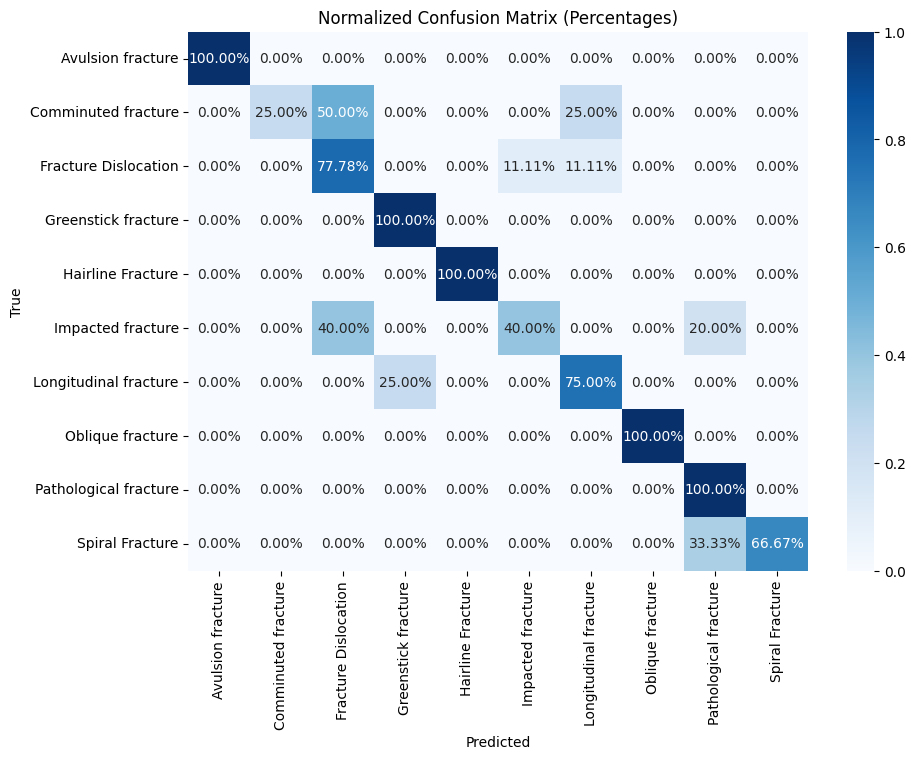

In [94]:
#computing conf. matrix
cm = confusion_matrix(vgg16_image_labels, vgg16_predicted_labels)

#normalizing confusion matrix by dividing each value by the total number of samples in the true class
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

#dsipalying confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix (Percentages)')
plt.show()